In [14]:
import pickle

annotated_jumps = []
#Michael Jumps
annotated_jumps.append({"takeoff_knee_bend": 42.9, "landing_knee_bend": 42.0})  # 1
annotated_jumps.append({"takeoff_knee_bend": 45.3, "landing_knee_bend": 45.8})  # 2
annotated_jumps.append({"takeoff_knee_bend": 41.4, "landing_knee_bend": 50.6})  # 3
annotated_jumps.append({"takeoff_knee_bend": 38.6, "landing_knee_bend": 39.8})  # 4
annotated_jumps.append({"takeoff_knee_bend": 78.5, "landing_knee_bend": 52.1})  # 5
annotated_jumps.append({"takeoff_knee_bend": 58.3, "landing_knee_bend": 57.3})  # 6
annotated_jumps.append({"takeoff_knee_bend": 68.0, "landing_knee_bend": 94.1})  # 7
annotated_jumps.append({"takeoff_knee_bend": 47.0, "landing_knee_bend": 55.5})  # 8
#Kevin Jumps
annotated_jumps.append({"takeoff_knee_bend": 41.2, "landing_knee_bend": 32.6})  # 1
annotated_jumps.append({"takeoff_knee_bend": 57.8, "landing_knee_bend": 35.7})  # 2
annotated_jumps.append({"takeoff_knee_bend": 102.6, "landing_knee_bend": 34.9}) # 3
annotated_jumps.append({"takeoff_knee_bend": 40.0, "landing_knee_bend": 37.8})  # 4
annotated_jumps.append({"takeoff_knee_bend": 48.6, "landing_knee_bend": 57.4})  # 5
annotated_jumps.append({"takeoff_knee_bend": 34.8, "landing_knee_bend": 24.5})  # 6
#Tanmay Jumps
annotated_jumps.append({"takeoff_knee_bend": 49.7, "landing_knee_bend": 24.3})  # 1
annotated_jumps.append({"takeoff_knee_bend": 42.6, "landing_knee_bend": 24.9})  # 2
annotated_jumps.append({"takeoff_knee_bend": 80.9, "landing_knee_bend": 22.2})  # 3
annotated_jumps.append({"takeoff_knee_bend": 49.8, "landing_knee_bend": 32.9})  # 4
annotated_jumps.append({"takeoff_knee_bend": 49.3, "landing_knee_bend": 27.8})  # 5
#Alireza Jumps
annotated_jumps.append({"takeoff_knee_bend": 48.6, "landing_knee_bend": 34.3})  # 1
annotated_jumps.append({"takeoff_knee_bend": 88.0, "landing_knee_bend": 27.3})  # 2
annotated_jumps.append({"takeoff_knee_bend": 45.9, "landing_knee_bend": 58.3})  # 3
annotated_jumps.append({"takeoff_knee_bend": 54.1, "landing_knee_bend": 24.8})  # 4
annotated_jumps.append({"takeoff_knee_bend": 53.3, "landing_knee_bend": 27.2})  # 5


data = []

file_paths = ["MichaelJumps.pkl", "KevinJumps.pkl", "TanmayJumps.pkl", "AlirezaJumps.pkl"]
amount = [8, 6, 5, 5]
for a,f in zip(amount, file_paths):
    with open(f, "rb") as f: data += pickle.load(f)[:a]
    print(len(data))

print(len(annotated_jumps))

8
14
19
24
24


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.signal import butter, filtfilt
from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import interp1d

In [4]:
def plot_jump(jump, starttime=-1, endtime=1e12, jump_index=None):    
    accel_data = jump.thigh_accel
    gyro_data = jump.thigh_gyro

    # Filter data within time window
    accel = accel_data[(accel_data[:, 0] >= starttime) & (accel_data[:, 0] <= endtime)]
    gyro = gyro_data[(gyro_data[:, 0] >= starttime) & (gyro_data[:, 0] <= endtime)]

    print("Plotting:", len(accel), "accel samples and", len(gyro), "gyro samples")

    time_accel = accel[:, 0]
    time_gyro = gyro[:, 0]

    ax, ay, az = accel[:, 1], accel[:, 2], accel[:, 3]
    gx_deg, gy_deg, gz_deg = gyro[:, 1], gyro[:, 2], gyro[:, 3]

    # ---- Double integrate acceleration to get displacement ----
    def compute_displacement(a, t):
        v = cumtrapz(a, t, initial=0)
        d = cumtrapz(v, t, initial=0)
        return d

    dx = compute_displacement(ax, time_accel)
    dy = compute_displacement(ay, time_accel)
    dz = compute_displacement(az, time_accel)

    # ---- Single integrate angular velocity (in deg/s) to get angular displacement (in degrees) ----
    def compute_rotation(g_deg, t):
        return cumtrapz(g_deg, t, initial=0)

    rx = compute_rotation(gx_deg, time_gyro)
    ry = compute_rotation(gy_deg, time_gyro)
    rz = compute_rotation(gz_deg, time_gyro)

    # ---- Plotting ----
    fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex='col')
    title = f"Jump {jump_index} - Sensor Data" if jump_index is not None else "Jump - Sensor Data"
    fig.suptitle(title)

    # Accelerometer raw
    axs[0, 0].plot(time_accel, ax, label='Ax')
    axs[0, 0].plot(time_accel, ay, label='Ay')
    axs[0, 0].plot(time_accel, az, label='Az')
    axs[0, 0].set_ylabel("Accel (m/s²)")
    axs[0, 0].set_title("Thigh Accelerometer - Raw")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Accelerometer displacement
    axs[0, 1].plot(time_accel, dx, label='Dx')
    axs[0, 1].plot(time_accel, dy, label='Dy')
    axs[0, 1].plot(time_accel, dz, label='Dz')
    axs[0, 1].set_title("Thigh Accelerometer - Displacement")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Gyroscope raw (angular velocity)
    axs[1, 0].plot(time_gyro, gx_deg, label='Gx (°/s)')
    axs[1, 0].plot(time_gyro, gy_deg, label='Gy (°/s)')
    axs[1, 0].plot(time_gyro, gz_deg, label='Gz (°/s)')
    axs[1, 0].set_ylabel("Gyro (°/s)")
    axs[1, 0].set_title("Thigh Gyroscope - Angular Velocity")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Gyroscope angular displacement (in degrees)
    axs[1, 1].plot(time_gyro, rx, label='Rx (°)')
    axs[1, 1].plot(time_gyro, ry, label='Ry (°)')
    axs[1, 1].plot(time_gyro, rz, label='Rz (°)')
    axs[1, 1].set_xlabel("Time (s)")
    axs[1, 1].set_title("Thigh Gyroscope - Angular Displacement")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




def plot_jump_displacements(jump, starttime=-1, endtime=1e20, jump_index=None):
    """
    Plot thigh displacement and angular displacement side by side.
    """

    # Filter displacement data within the time window
    disp_data = jump.thigh_disp
    ang_disp_data = jump.thigh_ang_disp

    disp = disp_data[(disp_data[:, 0] >= starttime) & (disp_data[:, 0] <= endtime)]
    ang_disp = ang_disp_data[(ang_disp_data[:, 0] >= starttime) & (ang_disp_data[:, 0] <= endtime)]

    print(f"Plotting: {len(disp)} displacement samples and {len(ang_disp)} angular displacement samples!")

    # Create the subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    title = f"Jump {jump_index + 1} - Displacements" if jump_index is not None else "Jump - Displacements"
    fig.suptitle(title)

    # Plot linear displacement
    axs[0].plot(disp[:, 0], disp[:, 1], label='Dx')
    axs[0].plot(disp[:, 0], disp[:, 2], label='Dy')
    axs[0].plot(disp[:, 0], disp[:, 3], label='Dz')
    axs[0].set_title("Thigh Displacement")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Displacement (m)")
    axs[0].legend()
    axs[0].grid(True)

    # Plot angular displacement
    axs[1].plot(ang_disp[:, 0], ang_disp[:, 1], label='Rx')
    axs[1].plot(ang_disp[:, 0], ang_disp[:, 2], label='Ry')
    axs[1].plot(ang_disp[:, 0], ang_disp[:, 3], label='Rz')
    axs[1].set_title("Thigh Angular Displacement")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Rotation (rad)")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

In [33]:
def low_pass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.

    Parameters:
    - data: numpy array of the signal to filter
    - cutoff: cutoff frequency in Hz
    - fs: sampling frequency in Hz
    - order: filter order (default: 4)

    Returns:
    - filtered_data: numpy array of filtered signal
    """
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def calculate_max_knee_bend(accel_data, starttime, endtime, co=0):
    timestamps = accel_data[:, 0]
    accel = accel_data[:, 1:]
    start_idx = np.abs(timestamps - starttime).argmin()
    end_idx = np.abs(timestamps - endtime).argmin()
    window = accel[start_idx : end_idx + 1]
    if window.shape[0] < 2:return 0
    ax, ay = window[:, 0], window[:, 1]
    if co > 0:
        ax = low_pass_filter(ax, co, 100)
        ay = low_pass_filter(ay, co, 100)

    pitch_rad = np.arctan2(-ay, ax)
    pitch_deg = np.degrees(pitch_rad)
    return min(np.max(np.abs(pitch_deg)), 100)  # max bend angle (degrees)




def calculate_max_knee_bend2(gyro_data, starttime, endtime, co=0):
    gyro_window = gyro_data[(gyro_data[:, 0] >= starttime) & (gyro_data[:, 0] <= endtime)]
    if len(gyro_window) < 2: return 0
    time = gyro_window[:, 0]
    gz_deg = gyro_window[:, 3]
    gz_rad = np.deg2rad(gz_deg)
    if co > 0: gz_rad = low_pass_filter(gz_rad, co, 100)
    angle_rad = cumtrapz(gz_rad, time, initial=0)
    angle_deg = np.degrees(angle_rad)
    return np.max(np.abs(angle_deg))  # max bend angle (degrees)




def calculate_max_knee_bend3(accel_data, starttime, endtime, co=0):
    timestamps = accel_data[:, 0]
    accel = accel_data[:, 1:]
    start_idx = np.abs(timestamps - starttime).argmin()
    end_idx = np.abs(timestamps - endtime).argmin()
    window = accel[start_idx : end_idx + 1]
    if window.shape[0] < 2: return 0
    ax, ay, az = window[:, 0], window[:, 1], window[:, 2]
    if co > 0:
        ax = low_pass_filter(ax, co, 100)
        ay = low_pass_filter(ay, co, 100)
        az = low_pass_filter(az, co, 100)

    acc_magnitude = np.sqrt(ax**2 + ay**2 + az**2)
    knee_angle_rad = np.arccos(ax / acc_magnitude)
    knee_angle_deg = np.degrees(knee_angle_rad)
    return np.max(np.abs(knee_angle_deg))

Jump 1:
Annotated: TakeOff = 42.900 deg | Landing = 42.000 deg
Plotting: 262 accel samples and 243 gyro samples


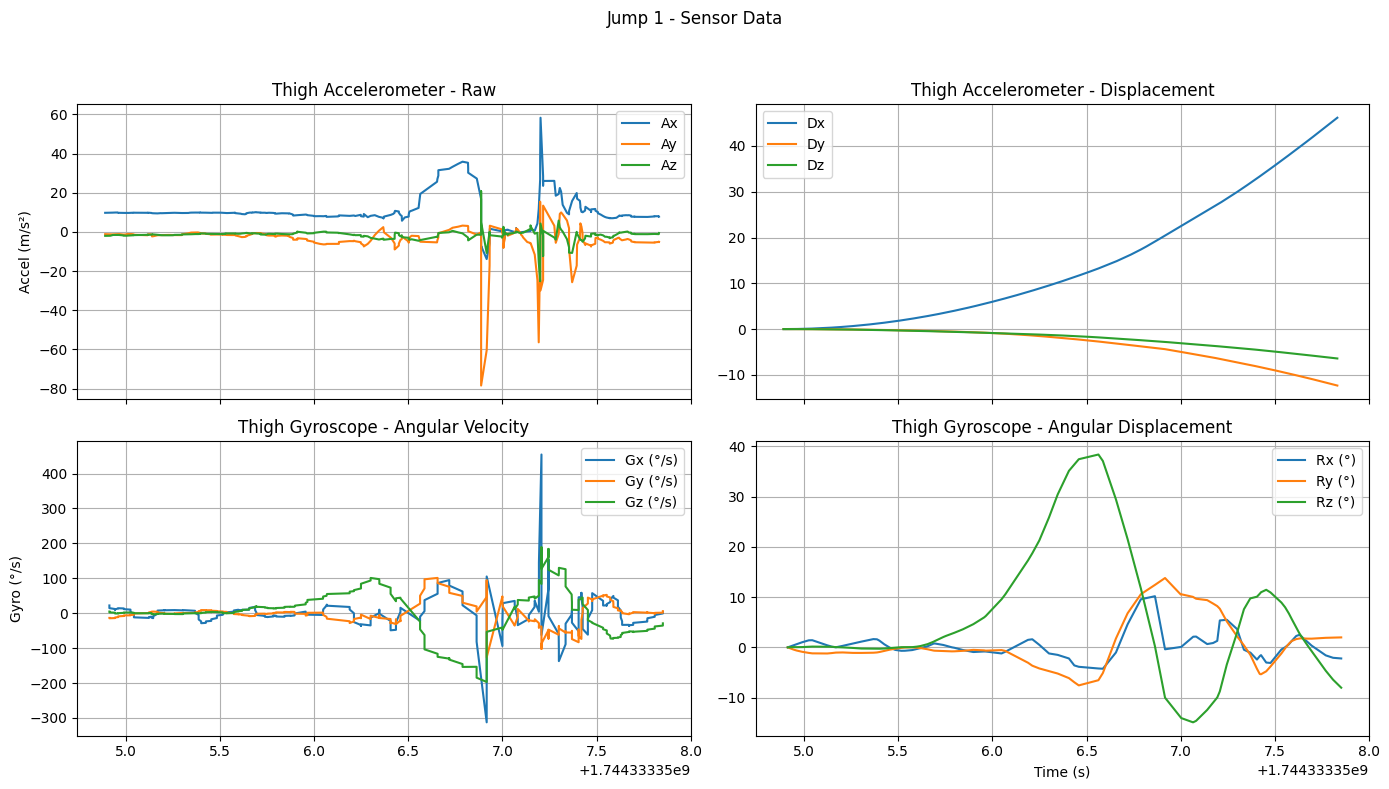

Jump 2:
Annotated: TakeOff = 45.300 deg | Landing = 45.800 deg
Plotting: 152 accel samples and 117 gyro samples


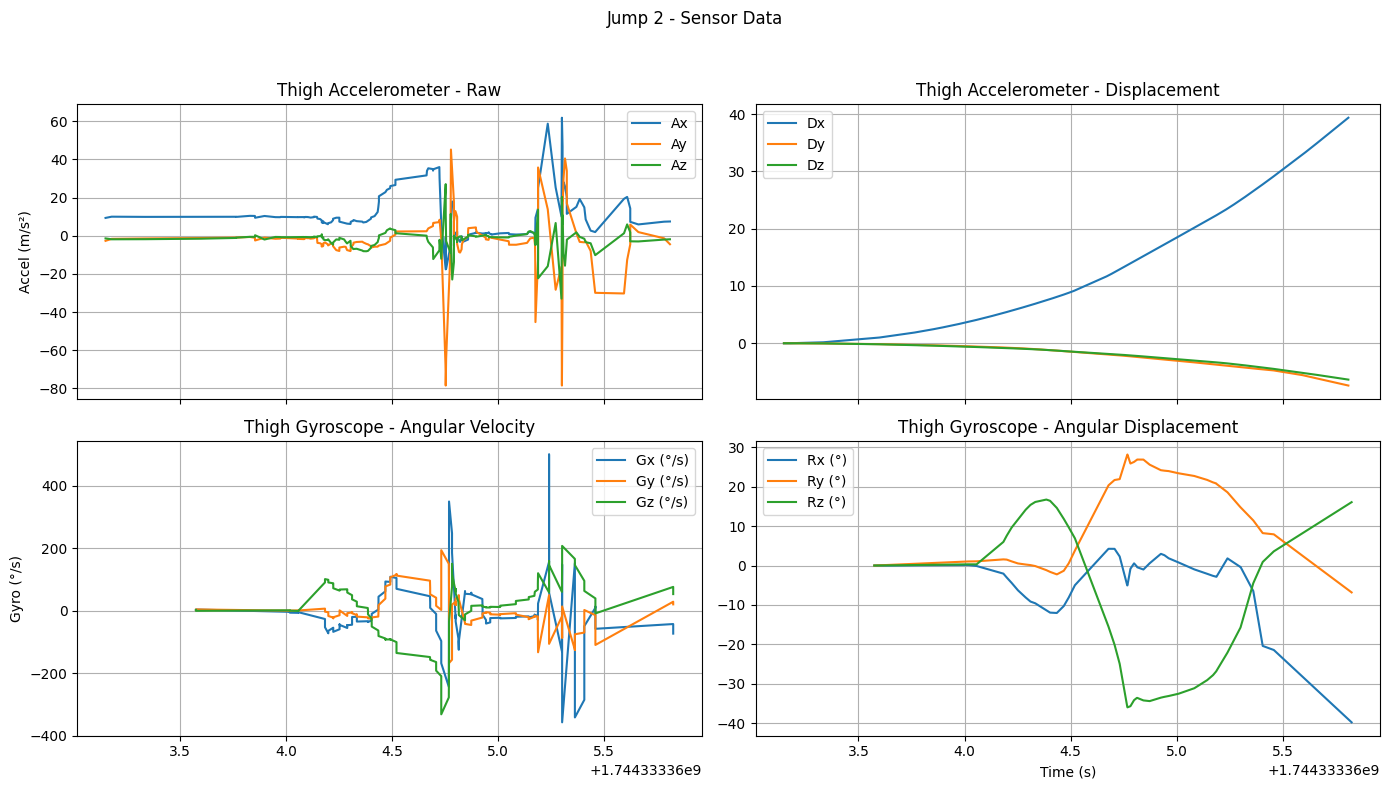

Jump 3:
Annotated: TakeOff = 41.400 deg | Landing = 50.600 deg
Plotting: 221 accel samples and 195 gyro samples


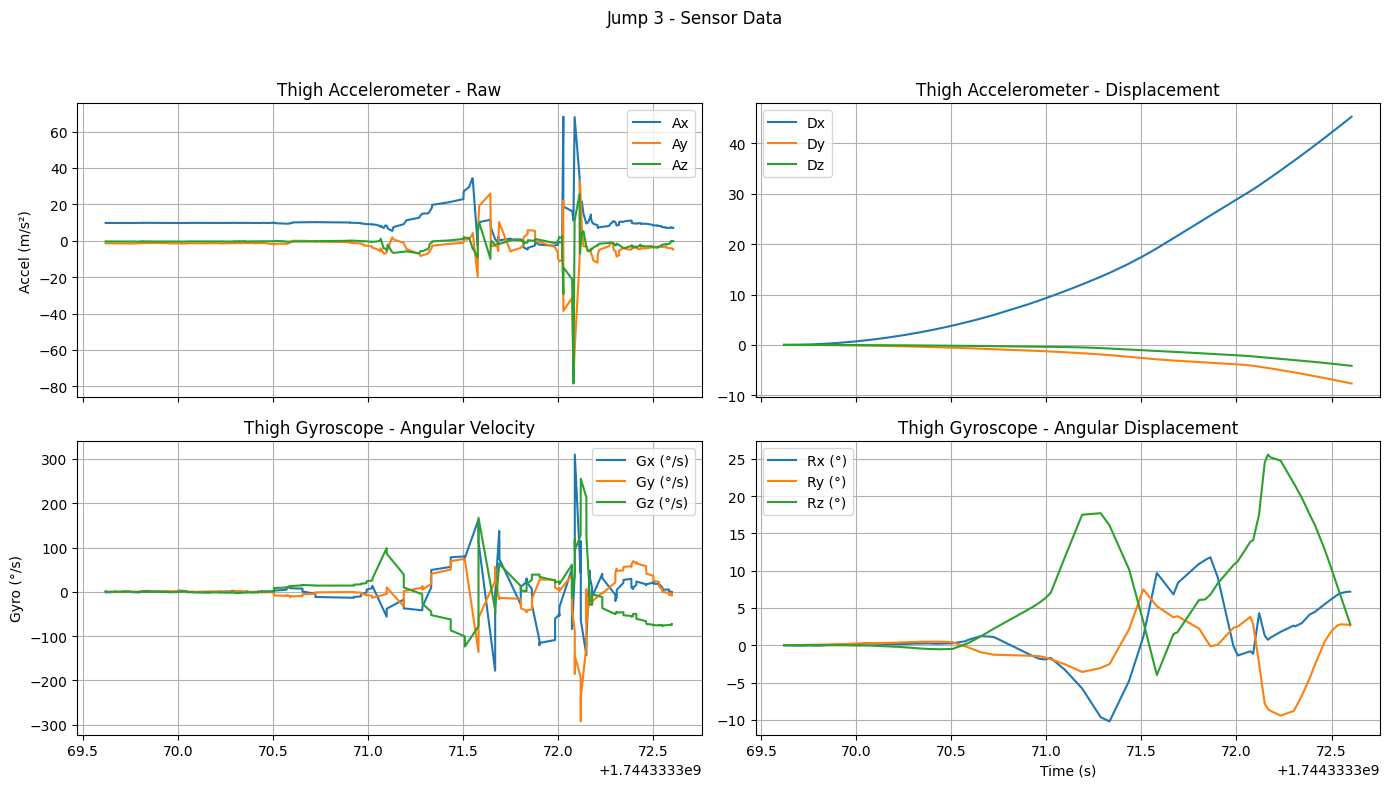

Jump 4:
Annotated: TakeOff = 38.600 deg | Landing = 39.800 deg
Plotting: 265 accel samples and 252 gyro samples


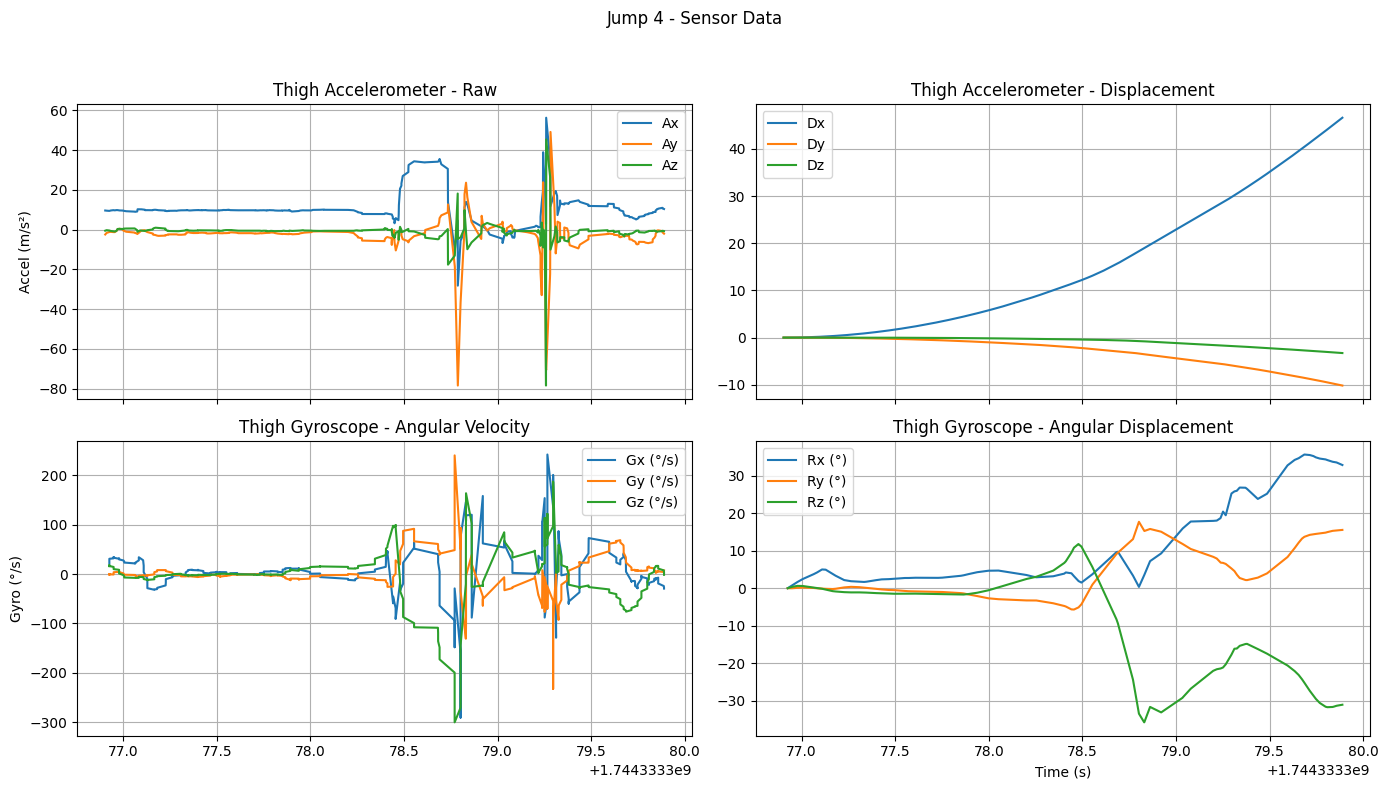

Jump 5:
Annotated: TakeOff = 78.500 deg | Landing = 52.100 deg
Plotting: 220 accel samples and 198 gyro samples


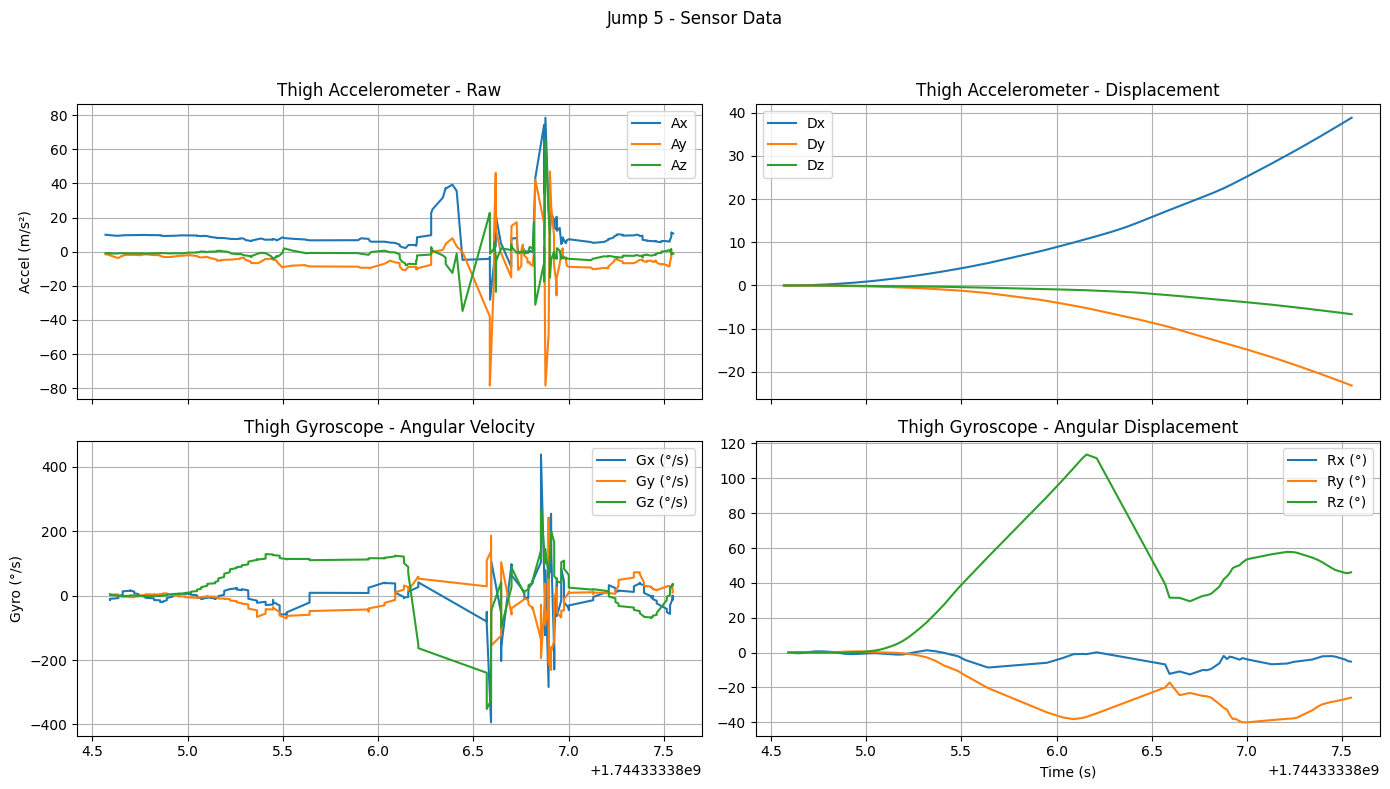

Jump 6:
Annotated: TakeOff = 58.300 deg | Landing = 57.300 deg
Plotting: 201 accel samples and 150 gyro samples


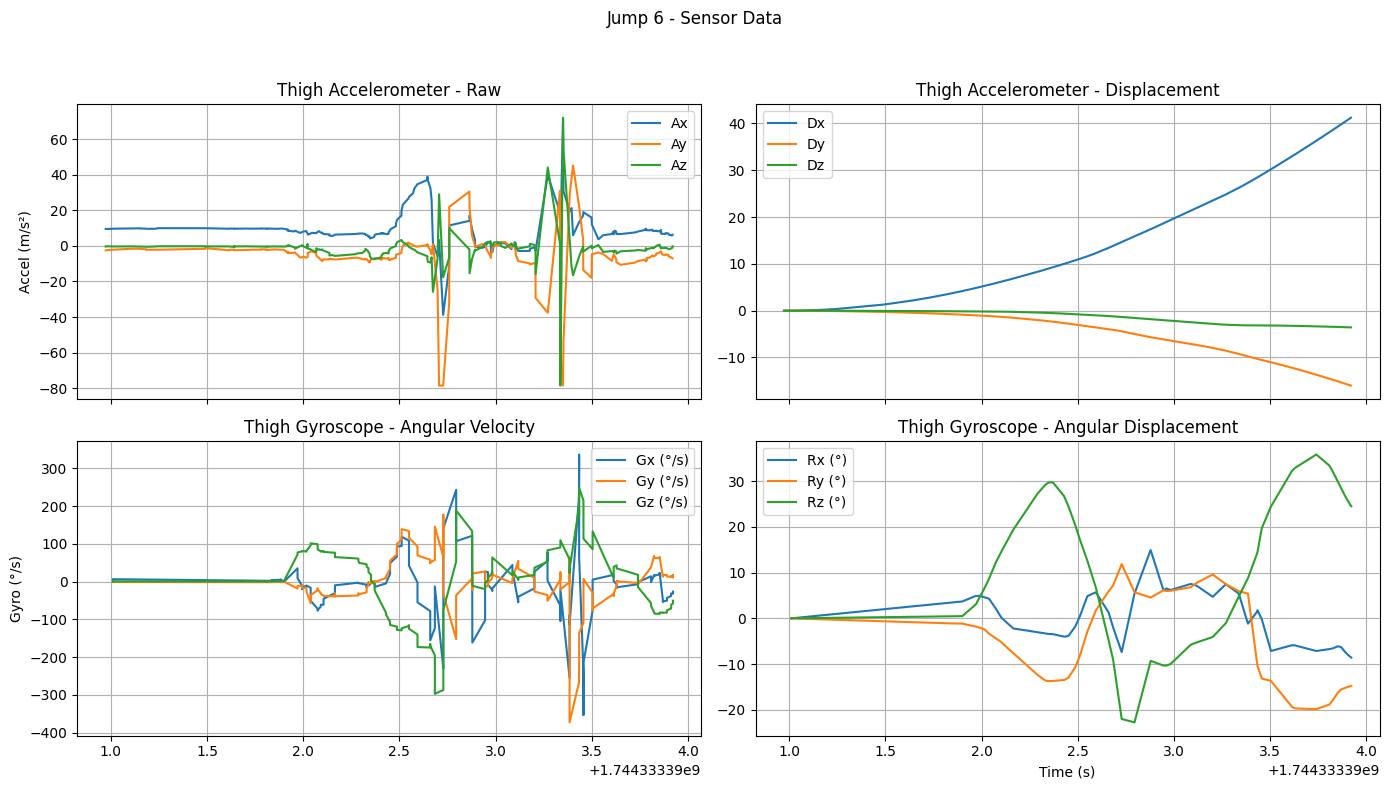

Jump 7:
Annotated: TakeOff = 68.000 deg | Landing = 94.100 deg
Plotting: 129 accel samples and 87 gyro samples


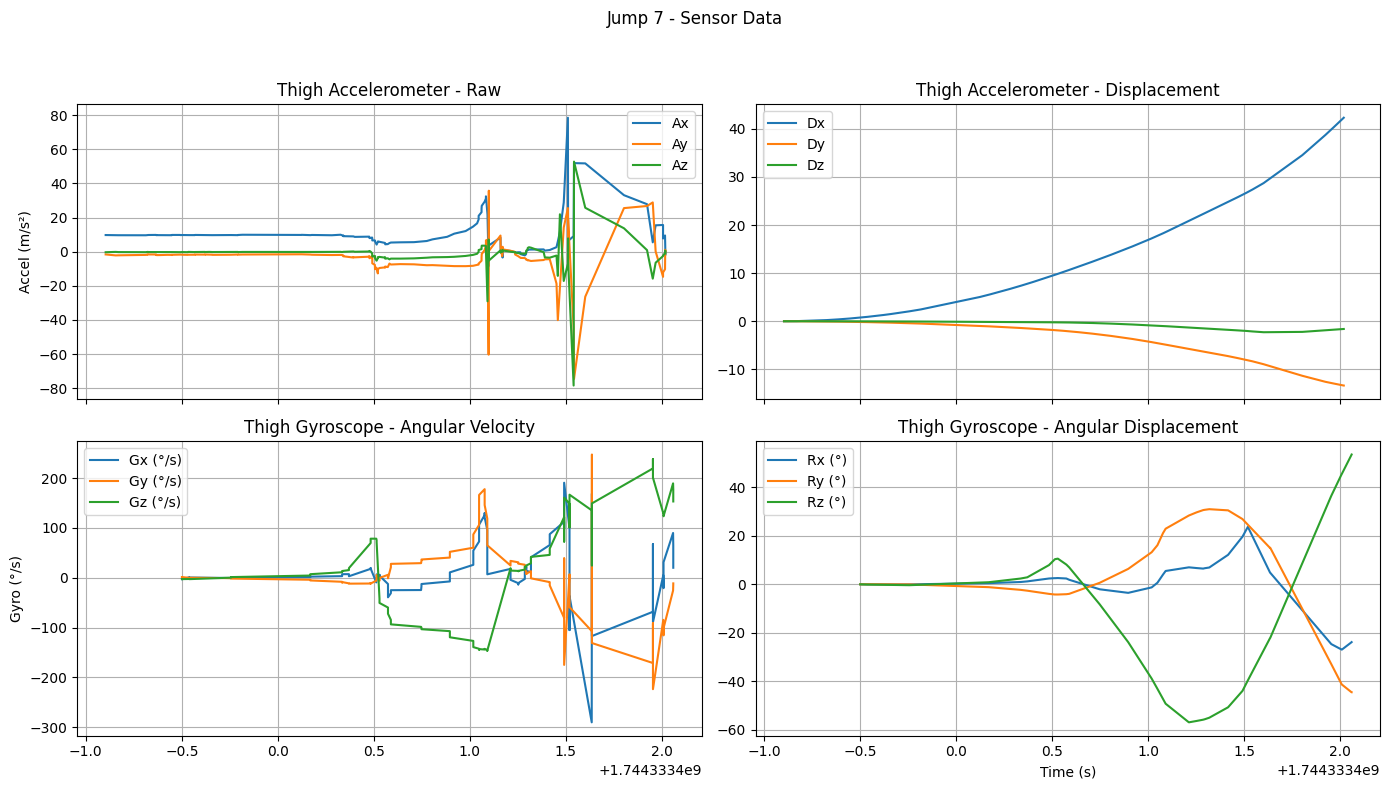

Jump 8:
Annotated: TakeOff = 47.000 deg | Landing = 55.500 deg
Plotting: 211 accel samples and 168 gyro samples


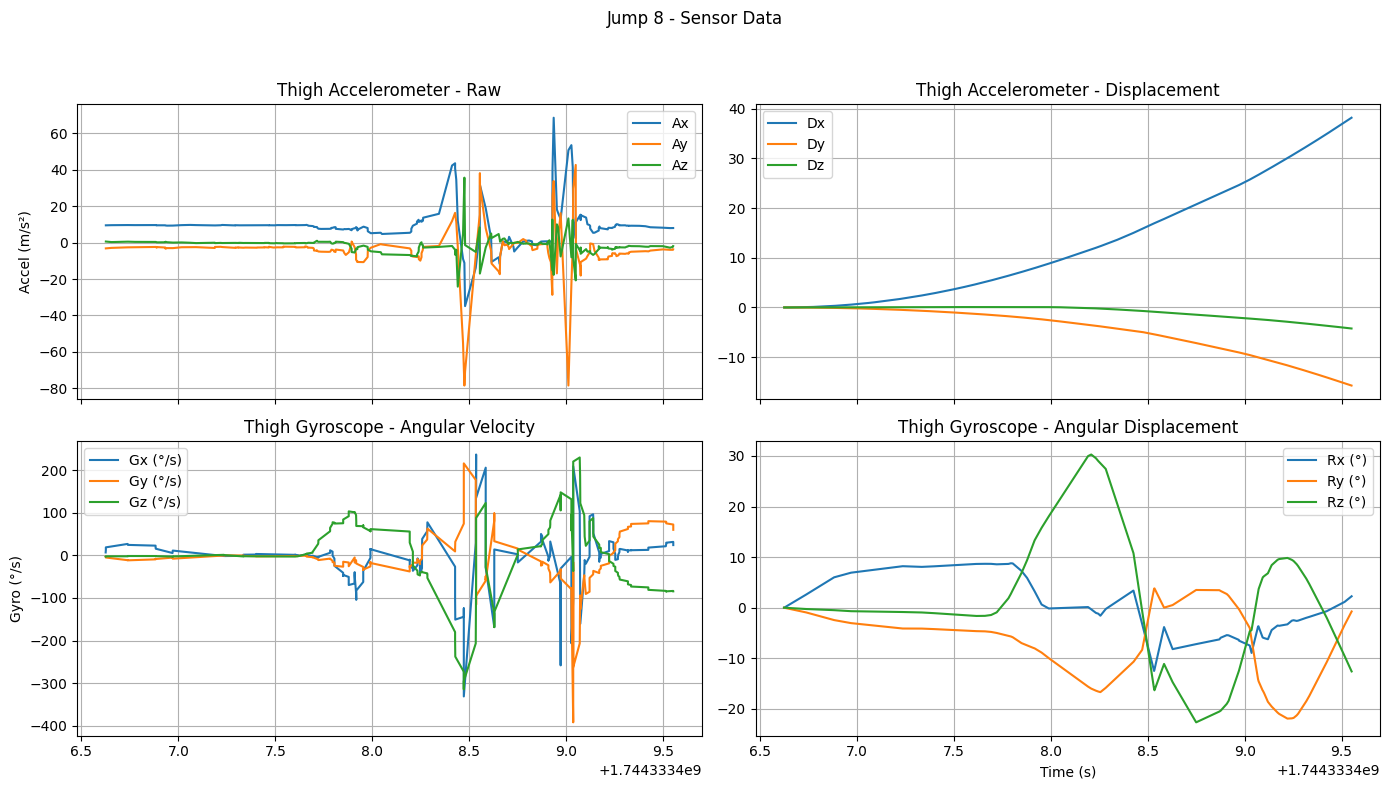

Jump 9:
Annotated: TakeOff = 41.200 deg | Landing = 32.600 deg
Plotting: 302 accel samples and 303 gyro samples


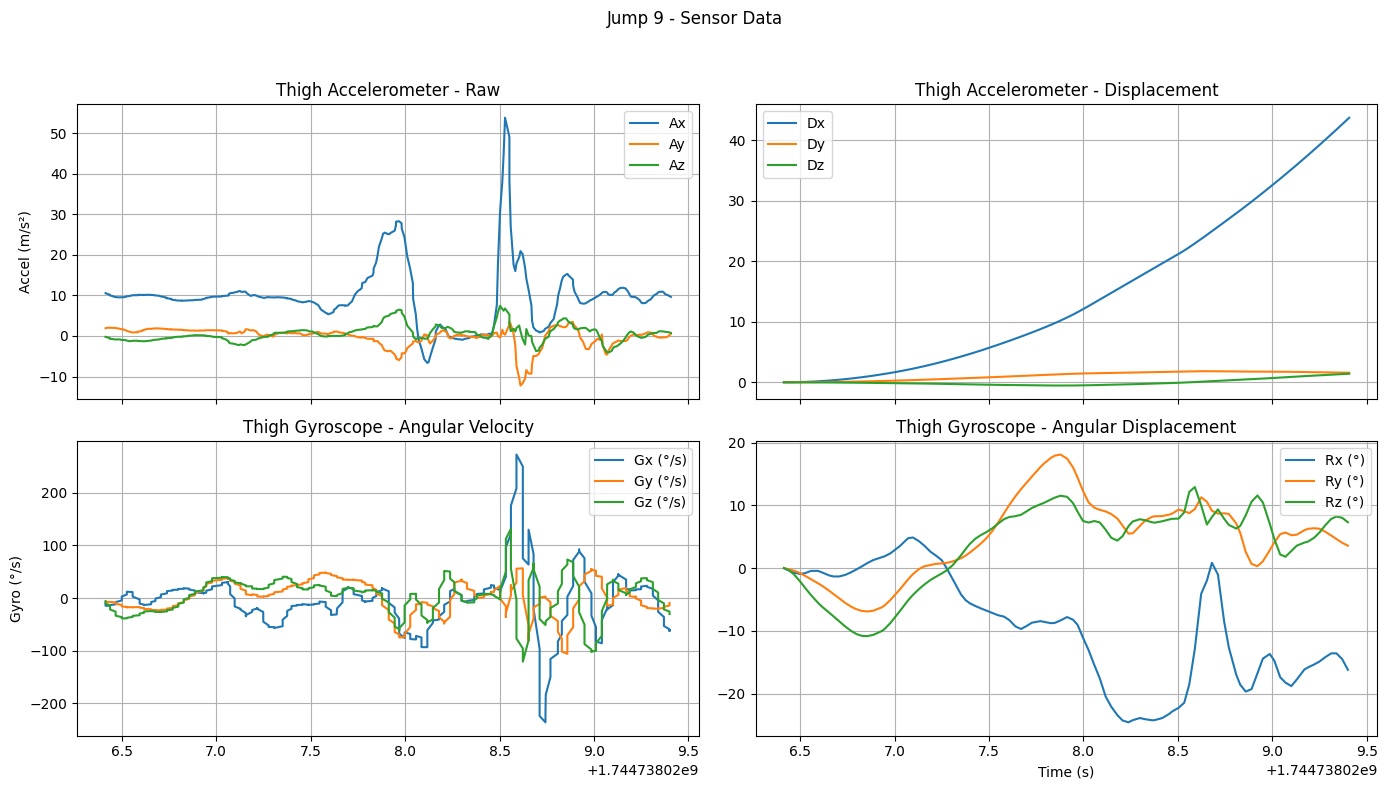

Jump 10:
Annotated: TakeOff = 57.800 deg | Landing = 35.700 deg
Plotting: 302 accel samples and 301 gyro samples


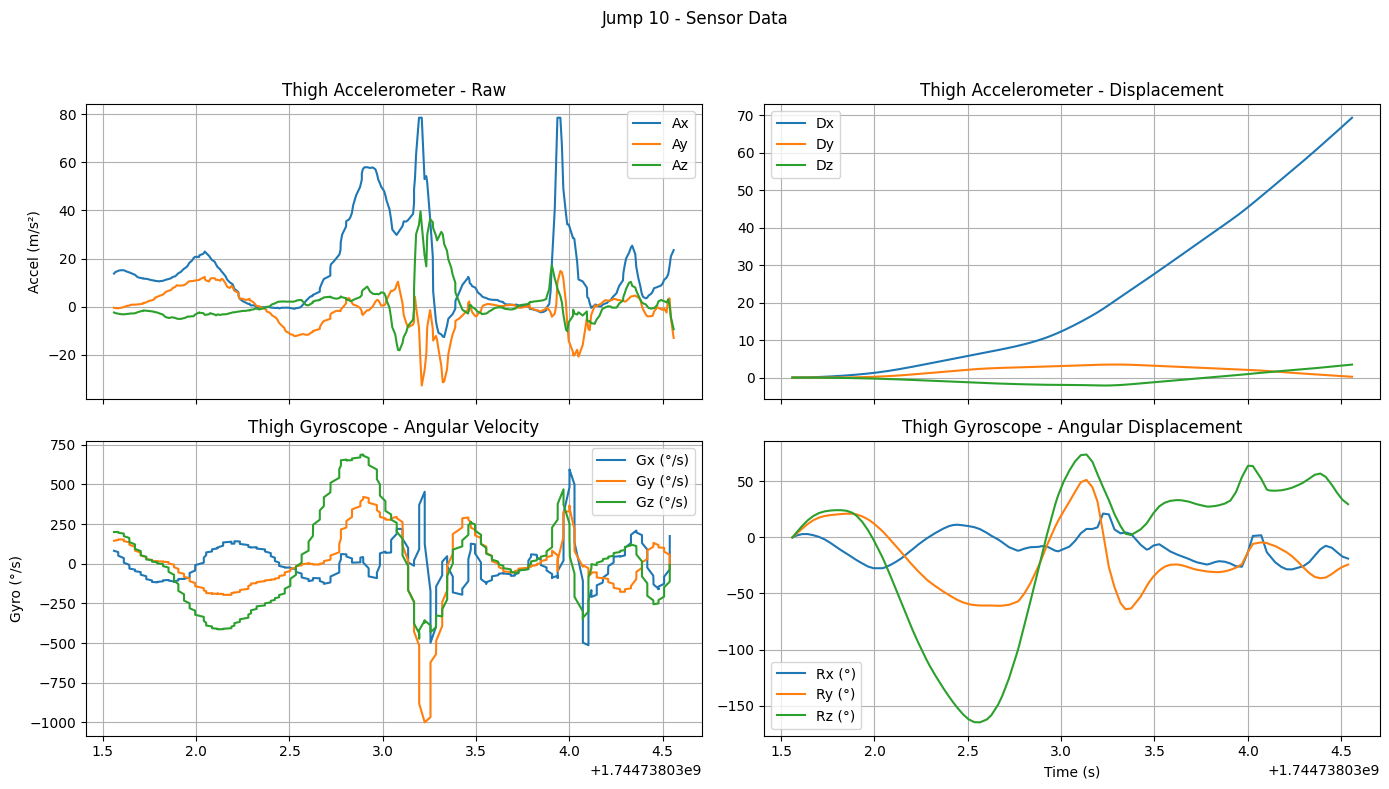

In [17]:
for i, jump in enumerate(data):
    if i == 10: break
    print(f"Jump {i+1}:")
    print(f"Annotated: TakeOff = {annotated_jumps[i]['takeoff_knee_bend']:.3f} deg | Landing = {annotated_jumps[i]['landing_knee_bend']:.3f} deg")

    takeoff_time, peak_time, landing_time = jump.partition

    #plot_jump_displacements(jump, endtime=takeoff_time+0.2, jump_index=i+1)

    plot_jump(jump, jump_index=i+1)

    #plot_jump(jump, endtime=takeoff_time+0.2, jump_index=i+1)

    #plot_jump(jump, starttime=landing_time-0.2, jump_index=i+1)

Jump 1:
Annotated: TakeOff = 42.9 deg | Landing = 42.0 deg
Calc 1 : TakeOff = 41.5 deg | Landing = 49.1 deg
Jump 2:
Annotated: TakeOff = 45.3 deg | Landing = 45.8 deg
Calc 1 : TakeOff = 52.6 deg | Landing = 60.6 deg
Jump 3:
Annotated: TakeOff = 41.4 deg | Landing = 50.6 deg
Calc 1 : TakeOff = 45.5 deg | Landing = 42.5 deg
Jump 4:
Annotated: TakeOff = 38.6 deg | Landing = 39.8 deg
Calc 1 : TakeOff = 63.1 deg | Landing = 60.6 deg
Jump 5:
Annotated: TakeOff = 78.5 deg | Landing = 52.1 deg
Calc 1 : TakeOff = 79.0 deg | Landing = 50.4 deg
Jump 6:
Annotated: TakeOff = 58.3 deg | Landing = 57.3 deg
Calc 1 : TakeOff = 62.9 deg | Landing = 51.9 deg
Jump 7:
Annotated: TakeOff = 68.0 deg | Landing = 94.1 deg
Calc 1 : TakeOff = 66.7 deg | Landing = 53.0 deg
Jump 8:
Annotated: TakeOff = 47.0 deg | Landing = 55.5 deg
Calc 1 : TakeOff = 56.7 deg | Landing = 55.6 deg
Jump 9:
Annotated: TakeOff = 41.2 deg | Landing = 32.6 deg
Calc 1 : TakeOff = 12.7 deg | Landing = 36.8 deg
Jump 10:
Annotated: TakeOff 

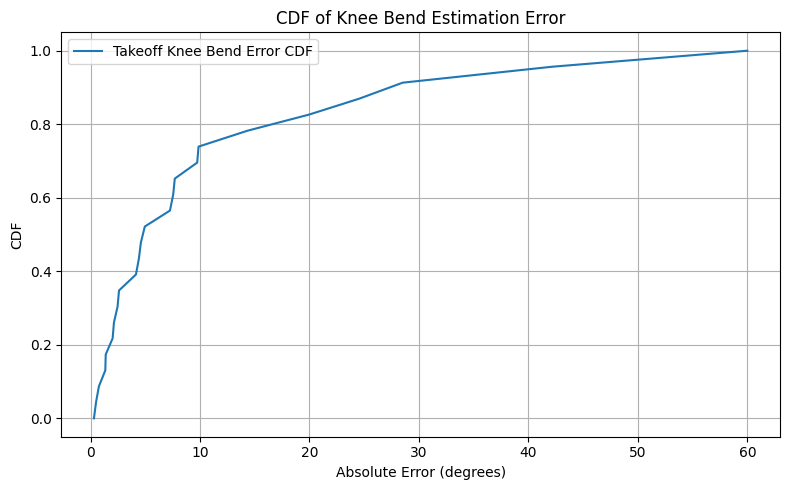

In [34]:
for i, jump in enumerate(data):
    if i == 25: break
    print(f"Jump {i+1}:")
    print(f"Annotated: TakeOff = {annotated_jumps[i]['takeoff_knee_bend']:.1f} deg | Landing = {annotated_jumps[i]['landing_knee_bend']:.1f} deg")

    takeoff_time, peak_time, landing_time = jump.partition

    #plot_jump_displacements(jump, endtime=takeoff_time+0.2, jump_index=i+1)
    #plot_jump(jump, endtime=takeoff_time+0.2, jump_index=i+1)

    jump.metrics['takeoff_knee_bend'] = calculate_max_knee_bend(jump.thigh_accel, 0, takeoff_time)
    #jump.metrics['landing_knee_bend'] = calculate_max_knee_bend(jump.thigh_accel, landing_time, jump.thigh_accel[-1][0])
    print(f"Calc 1 : TakeOff = {jump.metrics['takeoff_knee_bend']:.1f} deg | Landing = {jump.metrics['landing_knee_bend']:.1f} deg")


    #for d in jump.thigh_gyro[(jump.thigh_gyro[:, 0] >= 0) & (jump.thigh_gyro[:, 0] <= takeoff_time)]:
    #    # Extract the time and gyro values
    #    time = d[0]  # Assuming time is in the first column
    #    x = d[1]  # Assuming x is in the second column
    #    y = d[2]  # Assuming y is in the third column
    #    z = d[3]  # Assuming z is in the fourth column
        
        # Print the time with 2 decimal places and the gyro values rounded to 1 decimal place
    #    print(f"Time: {time:.2f}s, x: {x:.1f}, y: {y:.1f}, z: {z:.1f}")

    #jump.metrics['takeoff_knee_bend'] = calculate_max_knee_bend2(jump.thigh_gyro, 0, takeoff_time)
    #jump.metrics['landing_knee_bend'] = calculate_max_knee_bend2(jump.thigh_gyro, landing_time, jump.thigh_accel[-1][0])
    #print(f"Calc 2 : TakeOff = {jump.metrics['takeoff_knee_bend']:.1f} deg | Landing = {jump.metrics['landing_knee_bend']:.1f} deg")

    #jump.metrics['takeoff_knee_bend'] = calculate_max_knee_bend3(jump.thigh_accel, 0, takeoff_time)
    #jump.metrics['landing_knee_bend'] = calculate_max_knee_bend3(jump.thigh_accel, landing_time, jump.thigh_accel[-1][0])
    #print(f"Calc 3 : TakeOff = {jump.metrics['takeoff_knee_bend']:.1f} deg | Landing = {jump.metrics['landing_knee_bend']:.1f} deg")


takeoff_errors = []

for i, jump in enumerate(data):
    annotated_takeoff = annotated_jumps[i]['takeoff_knee_bend']
    calculated_takeoff = jump.metrics['takeoff_knee_bend']

    takeoff_errors.append(abs(calculated_takeoff - annotated_takeoff))

# Sort errors and compute CDF values
takeoff_errors_sorted = np.sort(takeoff_errors)
p = np.linspace(0, 1, len(takeoff_errors_sorted))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(takeoff_errors_sorted, p, label="Takeoff Knee Bend Error CDF")
plt.xlabel("Absolute Error (degrees)")
plt.ylabel("CDF")
plt.title("CDF of Knee Bend Estimation Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
def combined_knee_bend(accel_data, gyro_data, starttime, endtime, co, alpha):
    accel_angle = calculate_max_knee_bend(accel_data, starttime, endtime, co)
    gyro_angle = calculate_max_knee_bend2(gyro_data, starttime, endtime, co)
    return alpha * gyro_angle + (1 - alpha) * accel_angle

heatmap = np.full((99, 10), np.nan)  # alpha from 1 to 99, co from 0 to 9

for alpha in range(1, 100):  # alpha from 1 to 99
    for co in range(0, 10):  # skip co = 0 to avoid invalid filter
        takeoff_errors = []
        landing_errors = []

        for i, jump in enumerate(data):
            takeoff_time, _, landing_time = jump.partition

            #takeoff_pred = combined_knee_bend(jump.thigh_accel, jump.thigh_gyro, 0, takeoff_time, co, alpha / 100)
            landing_pred = combined_knee_bend(jump.thigh_accel, jump.thigh_gyro, landing_time, jump.thigh_accel[-1][0], co, alpha / 100)

            #takeoff_errors.append((takeoff_pred - annotated_jumps[i]['takeoff_knee_bend']) ** 2)
            landing_errors.append((landing_pred - annotated_jumps[i]['landing_knee_bend']) ** 2)

        heatmap[alpha - 1, co] = np.mean(landing_errors) #np.mean(takeoff_errors)np.mean(landing_errors) / 2

# Plotting the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(heatmap, aspect='auto', cmap='plasma_r', origin='lower')
plt.colorbar(label='MSE (Darker = Higher Error)')
plt.xlabel('Cutoff Frequency (Hz)')
plt.ylabel('Alpha (%)')
plt.title('Complementary Filter MSE Heatmap')
plt.xticks(ticks=np.arange(10), labels=np.arange(0, 10))
plt.yticks(ticks=np.arange(0, 99, 10), labels=np.arange(1, 100, 10))
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [86]:
min_idx = np.nanargmin(heatmap)
best_alpha_idx, best_co = np.unravel_index(min_idx, heatmap.shape)
best_alpha = best_alpha_idx + 1          # because row 0 = alpha=1
best_mse = heatmap[best_alpha_idx, best_co]

print(f"Lowest MSE = {best_mse:.4f} at α = {best_alpha}%, cutoff = {best_co} Hz")

Lowest MSE = 214.4666 at α = 68%, cutoff = 1 Hz


In [19]:
def combined_knee_bend(accel_data, gyro_data, starttime, endtime, co, alpha):
    accel_angle = calculate_max_knee_bend(accel_data, starttime, endtime, co)
    gyro_angle = calculate_max_knee_bend2(gyro_data, starttime, endtime, co)
    return alpha * gyro_angle + (1 - alpha) * accel_angle

In [7]:
heatmap = np.full((99, 10), np.nan)  # alpha from 1 to 99, co from 0 to 9

for alpha in range(1, 100):  # alpha from 1 to 99
    for co in range(0, 10):  # skip co = 0 to avoid invalid filter
        takeoff_errors = []
        landing_errors = []

        for i, jump in enumerate(data):
            takeoff_time, _, landing_time = jump.partition

            #takeoff_pred = combined_knee_bend(jump.thigh_accel, jump.thigh_gyro, 0, takeoff_time, co, alpha / 100)
            landing_pred = combined_knee_bend(jump.thigh_accel, jump.thigh_gyro, landing_time, jump.thigh_accel[-1][0], co, alpha / 100)

            #takeoff_errors.append(abs(takeoff_pred - annotated_jumps[i]['takeoff_knee_bend']))
            landing_errors.append(abs(landing_pred - annotated_jumps[i]['landing_knee_bend']))

        heatmap[alpha - 1, co] = np.sum(takeoff_errors) #+ np.sum(landing_errors)

# Plotting the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(heatmap, aspect='auto', cmap='plasma_r', origin='lower')
plt.colorbar(label='MSE (Darker = Higher Error)')
plt.xlabel('Cutoff Frequency (Hz)')
plt.ylabel('Alpha (%)')
plt.title('Complementary Filter SumError Heatmap')
plt.xticks(ticks=np.arange(10), labels=np.arange(0, 10))
plt.yticks(ticks=np.arange(0, 99, 10), labels=np.arange(1, 100, 10))
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [20]:
min_idx = np.nanargmin(heatmap)
best_alpha_idx, best_co = np.unravel_index(min_idx, heatmap.shape)
best_alpha = best_alpha_idx + 1          # because row 0 = alpha=1
best_sum_error = heatmap[best_alpha_idx, best_co]

print(f"Lowest SumError = {best_sum_error:.4f} at α = {best_alpha}%, cutoff = {best_co} Hz")

Lowest SumError = 374.9442 at α = 1%, cutoff = 9 Hz


Jump 1:
Annotated: TakeOff = 42.900 deg | Landing = 42.000 deg
Calc     : TakeOff = 41.513 deg | Landing = 39.250 deg
Jump 2:
Annotated: TakeOff = 45.300 deg | Landing = 45.800 deg
Calc     : TakeOff = 52.554 deg | Landing = 35.364 deg
Jump 3:
Annotated: TakeOff = 41.400 deg | Landing = 50.600 deg
Calc     : TakeOff = 45.548 deg | Landing = 36.157 deg
Jump 4:
Annotated: TakeOff = 38.600 deg | Landing = 39.800 deg
Calc     : TakeOff = 63.148 deg | Landing = 35.221 deg
Jump 5:
Annotated: TakeOff = 78.500 deg | Landing = 52.100 deg
Calc     : TakeOff = 78.998 deg | Landing = 38.244 deg
Jump 6:
Annotated: TakeOff = 58.300 deg | Landing = 57.300 deg
Calc     : TakeOff = 62.897 deg | Landing = 50.232 deg
Jump 7:
Annotated: TakeOff = 68.000 deg | Landing = 94.100 deg
Calc     : TakeOff = 66.653 deg | Landing = 35.992 deg
Jump 8:
Annotated: TakeOff = 47.000 deg | Landing = 55.500 deg
Calc     : TakeOff = 56.742 deg | Landing = 50.017 deg
Jump 9:
Annotated: TakeOff = 41.200 deg | Landing = 32.6

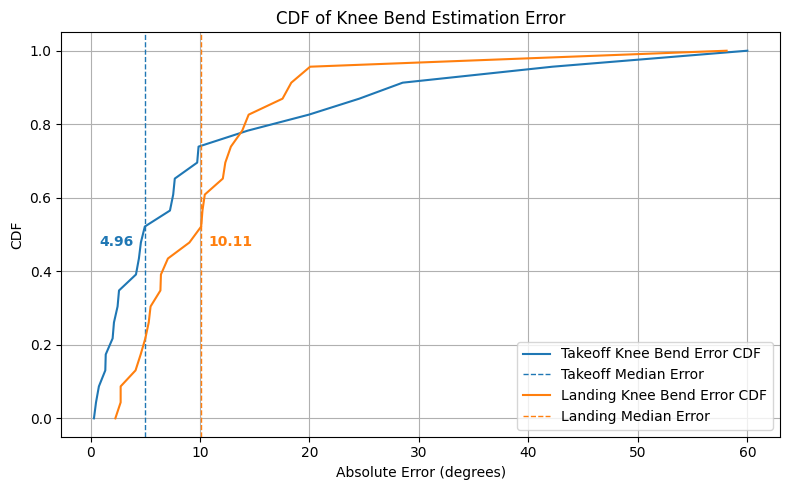

In [54]:
for i, jump in enumerate(data):
    print(f"Jump {i+1}:")
    print(f"Annotated: TakeOff = {annotated_jumps[i]['takeoff_knee_bend']:.3f} deg | Landing = {annotated_jumps[i]['landing_knee_bend']:.3f} deg")
    takeoff_time, peak_time, landing_time = jump.partition
    #jump.metrics['takeoff_knee_bend'] = combined_knee_bend(jump.thigh_accel, jump.thigh_gyro, 0, takeoff_time, 9, 0.5)
    jump.metrics['takeoff_knee_bend'] = calculate_max_knee_bend(jump.thigh_accel, 0, takeoff_time)
    jump.metrics['landing_knee_bend'] = combined_knee_bend(jump.thigh_accel, jump.thigh_gyro, landing_time, jump.thigh_accel[-1][0], 1, 0.68)
    print(f"Calc     : TakeOff = {jump.metrics['takeoff_knee_bend']:.3f} deg | Landing = {jump.metrics['landing_knee_bend']:.3f} deg")


takeoff_errors = []
landing_errors = []

for i, jump in enumerate(data):
    annotated_takeoff = annotated_jumps[i]['takeoff_knee_bend']
    annotated_landing = annotated_jumps[i]['landing_knee_bend']
    calculated_takeoff = jump.metrics['takeoff_knee_bend']
    calculated_landing = jump.metrics['landing_knee_bend']

    takeoff_errors.append(abs(calculated_takeoff - annotated_takeoff))
    landing_errors.append(abs(calculated_landing - annotated_landing))

# Sort errors and compute CDF values
takeoff_errors_sorted = np.sort(takeoff_errors)
landing_errors_sorted = np.sort(landing_errors)
p = np.linspace(0, 1, len(takeoff_errors_sorted))

# Plot
# Plot
plt.figure(figsize=(8, 5))

# Get line colors
takeoff_color = line1.get_color()  # usually blue
landing_color = line2.get_color()  # usually orange

# Median index
idx_50 = int(len(p) * 0.5)

# Values at 50th percentile
takeoff_val = takeoff_errors_sorted[idx_50]
landing_val = landing_errors_sorted[idx_50]

# Add vertical dotted lines
line1, = plt.plot(takeoff_errors_sorted, p, label="Takeoff Knee Bend Error CDF")
median_takeoff_line = plt.axvline(takeoff_val, color=takeoff_color, linestyle="--", linewidth=1, label="Takeoff Median Error")
line2, = plt.plot(landing_errors_sorted, p, label="Landing Knee Bend Error CDF")
median_landing_line = plt.axvline(landing_val, color=landing_color, linestyle="--", linewidth=1, label="Landing Median Error")


# Add labels under x-axis with alignment tweaks
plt.text(takeoff_val-1, 0.5, f"{takeoff_val:.2f}", color=takeoff_color,
         ha="right", va="top", rotation=0, weight='bold')

plt.text(landing_val+0.7, 0.5, f"{landing_val:.2f}", color=landing_color,
         ha="left", va="top", rotation=0, weight='bold')

# Final touches
plt.xlabel("Absolute Error (degrees)")
plt.ylabel("CDF")
plt.title("CDF of Knee Bend Estimation Error")
plt.grid(True)
plt.legend()
plt.ylim(-0.05, 1.05)  # make space for text
plt.tight_layout()
plt.show()



In [52]:
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.interpolate import interp1d
from filterpy.kalman import KalmanFilter

def lowpass_filter(data, cutoff_freq, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def kalman_max_knee_bend(accel_data, gyro_data, start_time, end_time, dt_default, gyro_axis='z', cutoff_freq=3, sample_rate=50):
    acc_filtered = [(t, (x, y, z)) for t, x, y, z in accel_data if start_time <= t <= end_time]
    gyro_filtered = [(t, (x, y, z)) for t, x, y, z in gyro_data if start_time <= t <= end_time]

    if len(acc_filtered) < 2 or len(gyro_filtered) < 2:
        return np.nan

    acc_times, acc_vals = zip(*acc_filtered)
    gyro_times, gyro_vals = zip(*gyro_filtered)

    acc_angles = [np.degrees(np.arctan2(-y, x)) for x, y, z in acc_vals]
    acc_angles_filtered = lowpass_filter(acc_angles, cutoff_freq, sample_rate)

    gyro_rates = [vals[{'x': 0, 'y': 1, 'z': 2}[gyro_axis]] for vals in gyro_vals]
    gyro_rates_filtered = lowpass_filter(gyro_rates, cutoff_freq, sample_rate)

    # Ensure sorted and unique times for interpolation
    gyro_times = np.array(gyro_times)
    gyro_rates_filtered = np.array(gyro_rates_filtered)
    sort_idx = np.argsort(gyro_times)
    gyro_times = gyro_times[sort_idx]
    gyro_rates_filtered = gyro_rates_filtered[sort_idx]

    gyro_interp = interp1d(gyro_times, gyro_rates_filtered, kind='linear', fill_value='extrapolate')
    gyro_synced = gyro_interp(acc_times)

    # Kalman filter setup
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([acc_angles_filtered[0], 0.])
    kf.H = np.array([[1., 0.]])
    kf.R = np.array([[5]])
    kf.Q = np.array([[1e-3, 0.], [0., 1e-2]])
    kf.P = np.eye(2)

    max_angle = -np.inf

    for i in range(1, len(acc_times)):
        t_prev = acc_times[i - 1]
        t_curr = acc_times[i]
        dt = t_curr - t_prev

        if dt <= 0 or dt > 1:  # sanity check
            dt = dt_default

        # Update F dynamically
        kf.F = np.array([[1., dt], [0., 1.]])

        acc_angle = acc_angles_filtered[i]
        gyro_rate = gyro_synced[i]

        if np.isnan(acc_angle) or np.isnan(gyro_rate):
            print(f"Skipping due to nan: acc_angle={acc_angle}, gyro_rate={gyro_rate}")
            continue

        # Predict with current state
        kf.predict()

        # Update with accelerometer measurement
        kf.update(np.array([acc_angle]))

        angle_deg = kf.x[0]
        max_angle = max(max_angle, abs(angle_deg))

        #print(f"Angle: {angle_deg:.2f} | Gyro rate: {gyro_rate:.2f} | Max Angle: {max_angle:.2f}")

    return max_angle if not np.isnan(max_angle) else np.nan

for i, jump in enumerate(data):
    if i == 25: break
    print(f"Jump {i+1}:")
    print(f"Annotated: TakeOff = {annotated_jumps[i]['takeoff_knee_bend']:.3f} deg | Landing = {annotated_jumps[i]['landing_knee_bend']:.3f} deg")

    takeoff_time, peak_time, landing_time = jump.partition

    acc_times = [t for t, x, y, z in jump.thigh_accel]
    dt = acc_times[1] - acc_times[0]

    takeoff_knee = kalman_max_knee_bend(jump.thigh_accel, jump.thigh_gyro,  
                                        min(acc_times + [t for t, x, y, z in jump.thigh_gyro]), takeoff_time, dt)
    landing_knee = kalman_max_knee_bend(jump.thigh_accel, jump.thigh_gyro, 
                                         landing_time, max(acc_times + [t for t, x, y, z in jump.thigh_gyro]), dt)

    jump.metrics['takeoff_knee_bend'] = takeoff_knee
    jump.metrics['landing_knee_bend'] = landing_knee

    print(f"Kalman : TakeOff = {takeoff_knee:.3f} deg | Landing = {landing_knee:.3f} deg")

Jump 1:
Annotated: TakeOff = 42.900 deg | Landing = 42.000 deg
Kalman : TakeOff = 28.525 deg | Landing = 106.017 deg
Jump 2:
Annotated: TakeOff = 45.300 deg | Landing = 45.800 deg
Kalman : TakeOff = 29.509 deg | Landing = 80.671 deg
Jump 3:
Annotated: TakeOff = 41.400 deg | Landing = 50.600 deg
Kalman : TakeOff = 19.615 deg | Landing = 135.807 deg
Jump 4:
Annotated: TakeOff = 38.600 deg | Landing = 39.800 deg
Skipping due to nan: acc_angle=9.167656632659954, gyro_rate=nan
Kalman : TakeOff = 24.624 deg | Landing = 167.648 deg
Jump 5:
Annotated: TakeOff = 78.500 deg | Landing = 52.100 deg
Kalman : TakeOff = 60.129 deg | Landing = 62.652 deg
Jump 6:
Annotated: TakeOff = 58.300 deg | Landing = 57.300 deg
Kalman : TakeOff = 48.159 deg | Landing = 97.354 deg
Jump 7:
Annotated: TakeOff = 68.000 deg | Landing = 94.100 deg
Skipping due to nan: acc_angle=10.683306655147247, gyro_rate=nan
Kalman : TakeOff = 43.495 deg | Landing = 120.837 deg
Jump 8:
Annotated: TakeOff = 47.000 deg | Landing = 55.

In [58]:
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.interpolate import interp1d
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# Lowpass filter
def lowpass_filter(data, cutoff_freq, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Kalman filter for max knee bend calculation
def kalman_max_knee_bend(accel_data, gyro_data, start_time, end_time, dt_default, gyro_axis='z', cutoff_freq=3, sample_rate=50, kf_R=5, kf_Q=1e-3):
    acc_filtered = [(t, (x, y, z)) for t, x, y, z in accel_data if start_time <= t <= end_time]
    gyro_filtered = [(t, (x, y, z)) for t, x, y, z in gyro_data if start_time <= t <= end_time]

    if len(acc_filtered) < 2 or len(gyro_filtered) < 2:
        return np.nan

    acc_times, acc_vals = zip(*acc_filtered)
    gyro_times, gyro_vals = zip(*gyro_filtered)

    acc_angles = [np.degrees(np.arctan2(-y, x)) for x, y, z in acc_vals]
    acc_angles_filtered = lowpass_filter(acc_angles, cutoff_freq, sample_rate)

    gyro_rates = [vals[{'x': 0, 'y': 1, 'z': 2}[gyro_axis]] for vals in gyro_vals]
    gyro_rates_filtered = lowpass_filter(gyro_rates, cutoff_freq, sample_rate)

    # Ensure sorted and unique times for interpolation
    gyro_times = np.array(gyro_times)
    gyro_rates_filtered = np.array(gyro_rates_filtered)
    sort_idx = np.argsort(gyro_times)
    gyro_times = gyro_times[sort_idx]
    gyro_rates_filtered = gyro_rates_filtered[sort_idx]

    gyro_interp = interp1d(gyro_times, gyro_rates_filtered, kind='linear', fill_value='extrapolate')
    gyro_synced = gyro_interp(acc_times)

    # Kalman filter setup
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([acc_angles_filtered[0], 0.])
    kf.H = np.array([[1., 0.]])
    kf.R = np.array([[kf_R]])  # Measurement noise covariance
    kf.Q = np.array([[kf_Q, 0.], [0., kf_Q]])  # Process noise covariance
    kf.P = np.eye(2)

    max_angle = -np.inf

    for i in range(1, len(acc_times)):
        t_prev = acc_times[i - 1]
        t_curr = acc_times[i]
        dt = t_curr - t_prev

        if dt <= 0 or dt > 1:  # sanity check
            dt = dt_default

        # Update F dynamically
        kf.F = np.array([[1., dt], [0., 1.]])

        acc_angle = acc_angles_filtered[i]
        gyro_rate = gyro_synced[i]

        if np.isnan(acc_angle) or np.isnan(gyro_rate):
            #print(f"Skipping due to nan: acc_angle={acc_angle}, gyro_rate={gyro_rate}")
            continue

        # Predict with current state
        kf.predict()

        # Update with accelerometer measurement
        kf.update(np.array([acc_angle]))

        angle_deg = kf.x[0]
        max_angle = max(max_angle, abs(angle_deg))

    return max_angle if not np.isnan(max_angle) else np.nan

# Grid search parameters
cutoff_freqs = [1,2, 3, 4,5]  # Lowpass filter cutoff frequencies to test
sample_rates = [50, 60, 70, 80, 100]  # Sample rates to test
kf_R_values = [0.1, 0.5, 1, 5, 10]  # Kalman filter measurement noise covariance
kf_Q_values = [1e-3, 1e-2, 1e-1, 0.05]  # Kalman filter process noise covariance

# Initialize best score tracking variables
best_score = np.inf
best_params = {}

# Iterate over the grid search parameters
for cutoff_freq in cutoff_freqs:
    for sample_rate in sample_rates:
        for kf_R in kf_R_values:
            for kf_Q in kf_Q_values:
                #print(f"Testing: cutoff_freq={cutoff_freq}, sample_rate={sample_rate}, kf_R={kf_R}, kf_Q={kf_Q}")
                
                total_takeoff_error = 0
                total_landing_error = 0
                count = 0
                
                # Loop over each jump in the data to calculate errors
                for i, jump in enumerate(data):
                    if i == 25: break
                    #print(f"Jump {i+1}:")
                    #print(f"Annotated: TakeOff = {annotated_jumps[i]['takeoff_knee_bend']:.3f} deg | Landing = {annotated_jumps[i]['landing_knee_bend']:.3f} deg")

                    takeoff_time, peak_time, landing_time = jump.partition
                    acc_times = [t for t, x, y, z in jump.thigh_accel]
                    dt = acc_times[1] - acc_times[0]

                    takeoff_knee = kalman_max_knee_bend(
                        jump.thigh_accel, jump.thigh_gyro,  
                        min(acc_times + [t for t, x, y, z in jump.thigh_gyro]), takeoff_time, dt, 
                        cutoff_freq=cutoff_freq, sample_rate=sample_rate, kf_R=kf_R, kf_Q=kf_Q
                    )

                    landing_knee = kalman_max_knee_bend(
                        jump.thigh_accel, jump.thigh_gyro, 
                        landing_time, max(acc_times + [t for t, x, y, z in jump.thigh_gyro]), dt,
                        cutoff_freq=cutoff_freq, sample_rate=sample_rate, kf_R=kf_R, kf_Q=kf_Q
                    )

                    jump.metrics['takeoff_knee_bend'] = takeoff_knee
                    jump.metrics['landing_knee_bend'] = landing_knee

                    # Calculate the error (MSE or other metric)
                    takeoff_error = (takeoff_knee - annotated_jumps[i]['takeoff_knee_bend']) ** 2
                    landing_error = (landing_knee - annotated_jumps[i]['landing_knee_bend']) ** 2

                    total_takeoff_error += takeoff_error
                    total_landing_error += landing_error
                    count += 1
                
                # Calculate the average error for this parameter combination
                avg_takeoff_error = np.sqrt(total_takeoff_error / count)
                avg_landing_error = np.sqrt(total_landing_error / count)

                #print(f"Avg Takeoff Error: {avg_takeoff_error:.3f} | Avg Landing Error: {avg_landing_error:.3f}")

                # Calculate total score (could be a weighted sum or other metric)
                total_error = avg_takeoff_error + avg_landing_error

                # Track the best parameters
                if total_error < best_score:
                    best_score = total_error
                    best_params = {
                        'cutoff_freq': cutoff_freq,
                        'sample_rate': sample_rate,
                        'kf_R': kf_R,
                        'kf_Q': kf_Q
                    }

print(f"Best Parameters: {best_params}")
print(f"Best Score (Error): {best_score}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Best Parameters: {'cutoff_freq': 2, 'sample_rate': 60, 'kf_R': 0.1, 'kf_Q': 0.01}
Best Score (Error): 62.21250401837965
